Matplotlib is building the font cache; this may take a moment.


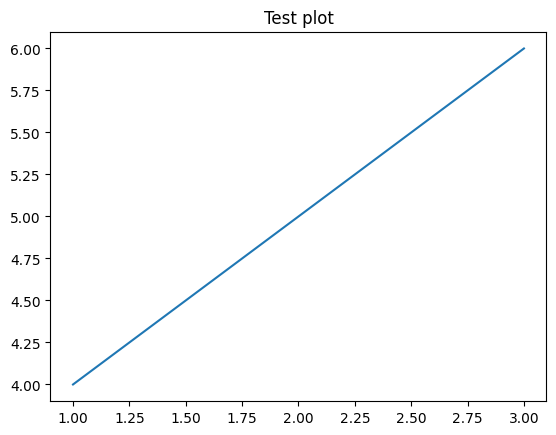

In [1]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], [4, 5, 6])
plt.title("Test plot")
plt.show()




In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [32]:
# Choisissez un seuil pour binariser y_test
threshold = 7.0  # Exemple: score IMDb de 7.0 comme seuil
y_test_binary = (y_test > threshold).astype(int)


In [33]:
# Faire des prédictions avec le modèle
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Seuil de 0.5 pour décider entre 0 et 1


294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


Précision du modèle sur le jeu de données de test : 0.48


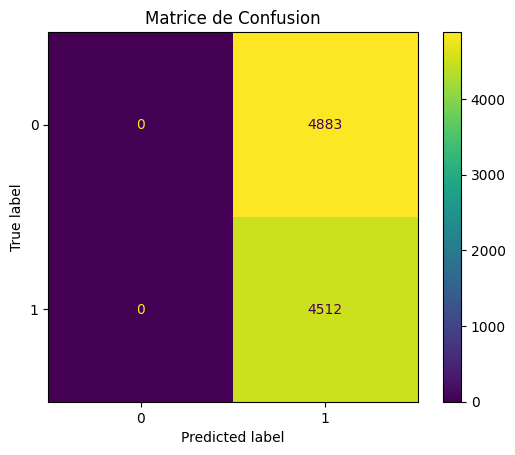

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Calculer la précision
accuracy = accuracy_score(y_test_binary, y_pred)
print(f"Précision du modèle sur le jeu de données de test : {accuracy:.2f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test_binary, y_pred)

# Afficher la matrice de confusion
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
plt.title('Matrice de Confusion')
plt.show()


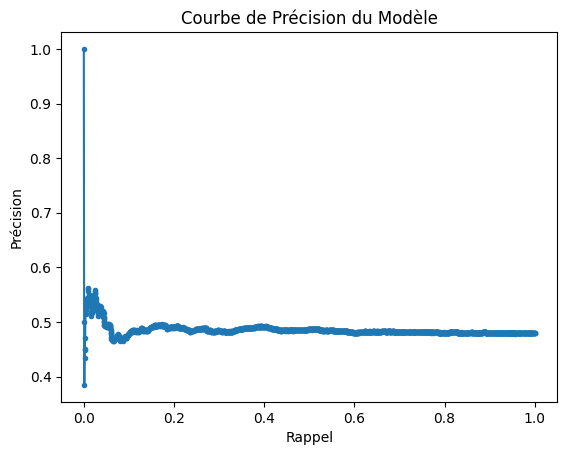

In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculer la courbe de précision et le rappel
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_prob)

# Tracer la courbe de précision
plt.plot(recall, precision, marker='.')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de Précision du Modèle')
plt.show()


In [36]:
print(y_test_binary.value_counts())


IMDb Score
0    4883
1    4512
Name: count, dtype: int64


In [42]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]



In [43]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Vous pouvez aussi utiliser 'median', 'most_frequent', etc.
X_train = imputer.fit_transform(X_train)


Précision du modèle sur le jeu de données de test : 0.65


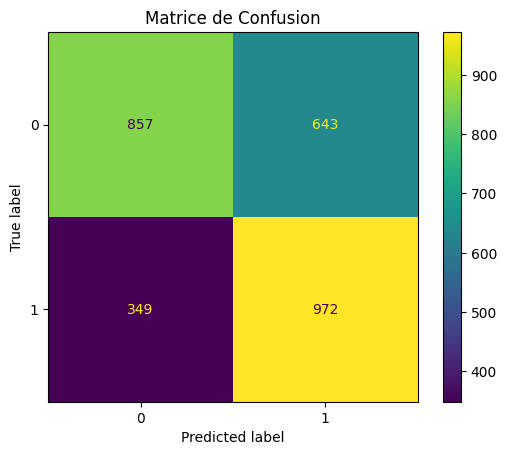

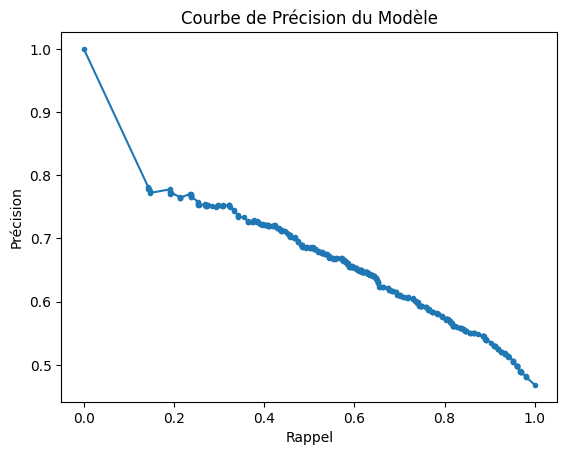

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt

# Charger les données
dataset_path = '../data/NetflixDataset.csv'
df_test = pd.read_csv(dataset_path, encoding='ISO-8859-1')

# Nettoyer les données (comme précédemment)
df_test['Runtime'] = df_test['Runtime'].fillna('').astype(str)

def convert_runtime(runtime_str):
    if '<' in runtime_str:
        return 15
    elif '1-2 hour' in runtime_str:
        return 90
    elif '> 2 hrs' in runtime_str:
        return 150
    else:
        return 60

df_test['Runtime'] = df_test['Runtime'].apply(convert_runtime)

def convert_boxoffice(boxoffice_value):
    if isinstance(boxoffice_value, str):
        boxoffice_value = boxoffice_value.replace('$', '').replace(',', '')
        try:
            return float(boxoffice_value)
        except ValueError:
            return np.nan
    return boxoffice_value

df_test['Boxoffice'] = df_test['Boxoffice'].apply(convert_boxoffice)

# Définir X et y
X = df_test[['IMDb Votes', 'Runtime', 'Boxoffice']]
y = df_test['IMDb Score']

# Binariser y
threshold = 7.0
y_binary = (y > threshold).astype(int)

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Gérer les valeurs manquantes dans X_train
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Gérer le déséquilibre des classes avec SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Entraîner un modèle de forêt aléatoire
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

# Gérer les valeurs manquantes dans X_test
X_test = imputer.transform(X_test)

# Faire des prédictions
y_pred_prob = model.predict_proba(X_test)[:, 1]
optimal_threshold = 0.3  # Essayez plusieurs valeurs
y_pred = (y_pred_prob > optimal_threshold).astype(int)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle sur le jeu de données de test : {accuracy:.2f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
plt.title('Matrice de Confusion')
plt.show()

# Tracer la courbe de précision
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de Précision du Modèle')
plt.show()


In [45]:
from sklearn.model_selection import GridSearchCV

# Définir une grille de paramètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialiser le modèle
rf = RandomForestClassifier(random_state=42)

# Appliquer GridSearchCV pour trouver les meilleurs paramètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Utiliser le meilleur modèle
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.8s
[CV] END m

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV] END m

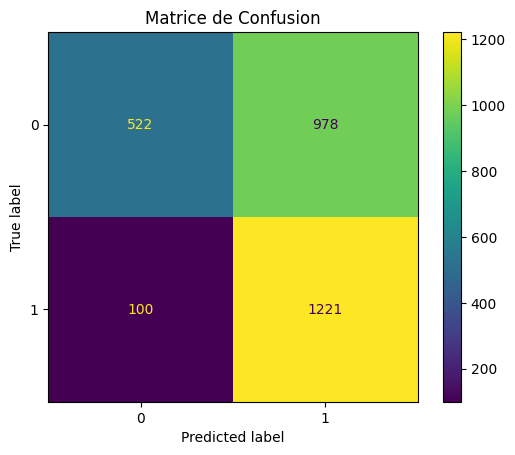

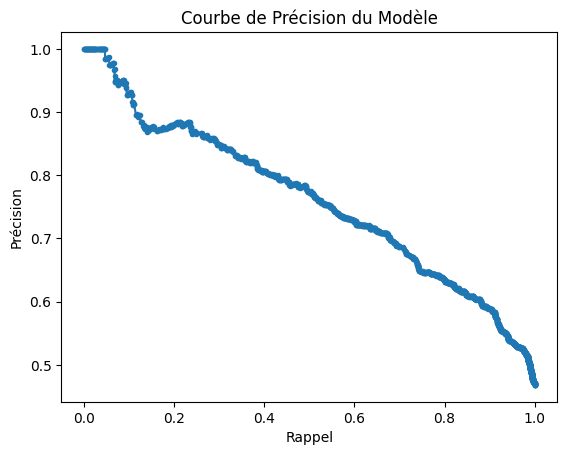

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt

# Charger les données
dataset_path = '../data/NetflixDataset.csv'
df_test = pd.read_csv(dataset_path, encoding='ISO-8859-1')

# Nettoyer les données
df_test['Runtime'] = df_test['Runtime'].fillna('').astype(str)

def convert_runtime(runtime_str):
    if '<' in runtime_str:
        return 15
    elif '1-2 hour' in runtime_str:
        return 90
    elif '> 2 hrs' in runtime_str:
        return 150
    else:
        return 60

df_test['Runtime'] = df_test['Runtime'].apply(convert_runtime)

def convert_boxoffice(boxoffice_value):
    if isinstance(boxoffice_value, str):
        boxoffice_value = boxoffice_value.replace('$', '').replace(',', '')
        try:
            return float(boxoffice_value)
        except ValueError:
            return np.nan
    return boxoffice_value

df_test['Boxoffice'] = df_test['Boxoffice'].apply(convert_boxoffice)

# Définir X et y
X = df_test[['IMDb Votes', 'Runtime', 'Boxoffice']]
y = df_test['IMDb Score']

# Binariser y
threshold = 7.0
y_binary = (y > threshold).astype(int)

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Gérer les valeurs manquantes dans X_train et X_test
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Gérer le déséquilibre des classes avec SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Réglage des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Utiliser le meilleur modèle trouvé par GridSearchCV
best_model = grid_search.best_estimator_

# Faire des prédictions
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
optimal_threshold = 0.3  # Expérimentez avec plusieurs valeurs si nécessaire
y_pred = (y_pred_prob > optimal_threshold).astype(int)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle sur le jeu de données de test : {accuracy:.2f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
plt.title('Matrice de Confusion')
plt.show()

# Tracer la courbe de précision
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de Précision du Modèle')
plt.show()


In [49]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate

# Charger les données
df = pd.read_csv('../data/NetflixDataset.csv', encoding='ISO-8859-1')

# Préparer les données pour Surprise
ratings = pd.DataFrame({
    'user_id': df.index,  # On utilise les indices des titres comme identifiants utilisateurs
    'item_id': df['Title'],
    'rating': df['IMDb Score']
})
reader = Reader(rating_scale=(df['IMDb Score'].min(), df['IMDb Score'].max()))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

# Diviser les données en ensembles d'entraînement et de test
trainset, testset = train_test_split(data, test_size=0.25)

# Entraîner un modèle SVD
model = SVD()
model.fit(trainset)

# Faire des prédictions sur l'ensemble de test
predictions = model.test(testset)

# Évaluer le modèle
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Exemple de recommandation
user_id = df.index[0]  # Exemple: recommander pour le premier utilisateur
item_id = df['Title'].iloc[0]  # Exemple: premier film dans le dataset
prediction = model.predict(user_id, item_id)
print(f"Prédiction pour l'utilisateur {user_id} et le film '{item_id}': {prediction.est}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    nan     nan     nan     nan     nan     nan     nan     
MAE (testset)     nan     nan     nan     nan     nan     nan     nan     
Fit time          0.06    0.08    0.07    0.06    0.07    0.07    0.01    
Test time         0.00    0.00    0.01    0.00    0.00    0.00    0.00    
Prédiction pour l'utilisateur 0 et le film 'Lets Fight Ghost': 9.7


In [50]:
print(df['IMDb Score'].isna().sum())


8


In [51]:
df['IMDb Score'] = pd.to_numeric(df['IMDb Score'], errors='coerce')


In [52]:
df = df.dropna(subset=['IMDb Score'])


In [53]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate

# Charger les données
df = pd.read_csv('../data/NetflixDataset.csv', encoding='ISO-8859-1')

# Vérifier et traiter les valeurs non numériques ou manquantes dans 'IMDb Score'
df['IMDb Score'] = pd.to_numeric(df['IMDb Score'], errors='coerce')
df = df.dropna(subset=['IMDb Score'])

# Préparer les données pour Surprise
ratings = pd.DataFrame({
    'user_id': df.index,  # On utilise les indices des titres comme identifiants utilisateurs
    'item_id': df['Title'],
    'rating': df['IMDb Score']
})
reader = Reader(rating_scale=(df['IMDb Score'].min(), df['IMDb Score'].max()))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

# Diviser les données en ensembles d'entraînement et de test
trainset, testset = train_test_split(data, test_size=0.25)

# Entraîner un modèle SVD
model = SVD()
model.fit(trainset)

# Faire des prédictions sur l'ensemble de test
predictions = model.test(testset)

# Évaluer le modèle
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Exemple de recommandation
user_id = df.index[0]  # Exemple: recommander pour le premier utilisateur
item_id = df['Title'].iloc[0]  # Exemple: premier film dans le dataset
prediction = model.predict(user_id, item_id)
print(f"Prédiction pour l'utilisateur {user_id} et le film '{item_id}': {prediction.est}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9122  0.9195  0.8832  0.8895  0.8853  0.8979  0.0149  
MAE (testset)     0.6919  0.6964  0.6868  0.6827  0.6795  0.6875  0.0061  
Fit time          0.07    0.07    0.08    0.06    0.07    0.07    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Prédiction pour l'utilisateur 0 et le film 'Lets Fight Ghost': 7.308895230256079


In [54]:
from surprise.model_selection import GridSearchCV

# Définir une grille de paramètres pour SVD
param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.4]
}

# Effectuer une recherche en grille pour trouver les meilleurs paramètres
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Afficher les meilleurs paramètres
print(gs.best_params['rmse'])

# Réentraîner le meilleur modèle
best_model = gs.best_estimator['rmse']
best_model.fit(trainset)


{'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.02}


In [55]:
# Réentraîner le meilleur modèle sur l'ensemble de données complet
best_model = gs.best_estimator['rmse']
best_model.fit(trainset)

# Faire des prédictions sur l'ensemble de test
predictions = best_model.test(testset)

# Réévaluer les performances du modèle optimisé
cross_validate(best_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Exemple de recommandation pour un utilisateur spécifique
user_id = df.index[0]  # Exemple: recommander pour le premier utilisateur
item_id = df['Title'].iloc[0]  # Exemple: premier film dans le dataset
prediction = best_model.predict(user_id, item_id)
print(f"Prédiction pour l'utilisateur {user_id} et le film '{item_id}': {prediction.est}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8968  0.8868  0.8899  0.9056  0.9059  0.8970  0.0079  
MAE (testset)     0.6830  0.6865  0.6746  0.6953  0.6932  0.6865  0.0074  
Fit time          0.04    0.04    0.05    0.05    0.05    0.04    0.01    
Test time         0.00    0.00    0.00    0.01    0.00    0.00    0.00    
Prédiction pour l'utilisateur 0 et le film 'Lets Fight Ghost': 7.326028092743951


In [56]:
best_model = gs.best_estimator['rmse']
best_model.fit(trainset)


In [57]:
predictions = best_model.test(testset)


In [58]:
cross_validate(best_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8942  0.9468  0.8838  0.8751  0.8842  0.8968  0.0257  
MAE (testset)     0.6899  0.7189  0.6697  0.6722  0.6821  0.6866  0.0177  
Fit time          0.04    0.04    0.06    0.04    0.05    0.05    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.89418287, 0.94680348, 0.88377303, 0.87508872, 0.88417782]),
 'test_mae': array([0.68990003, 0.71891264, 0.66972524, 0.67222828, 0.68209492]),
 'fit_time': (0.04347801208496094,
  0.04358696937561035,
  0.06197190284729004,
  0.04470086097717285,
  0.05366182327270508),
 'test_time': (0.0037949085235595703,
  0.003859996795654297,
  0.004578828811645508,
  0.003983974456787109,
  0.004060029983520508)}

In [59]:
user_id = df.index[0]  # Exemple: recommander pour le premier utilisateur
item_id = df['Title'].iloc[0]  # Exemple: premier film dans le dataset
prediction = best_model.predict(user_id, item_id)
print(f"Prédiction pour l'utilisateur {user_id} et le film '{item_id}': {prediction.est}")


Prédiction pour l'utilisateur 0 et le film 'Lets Fight Ghost': 7.36496874316304


Précision du modèle binaire : 0.49


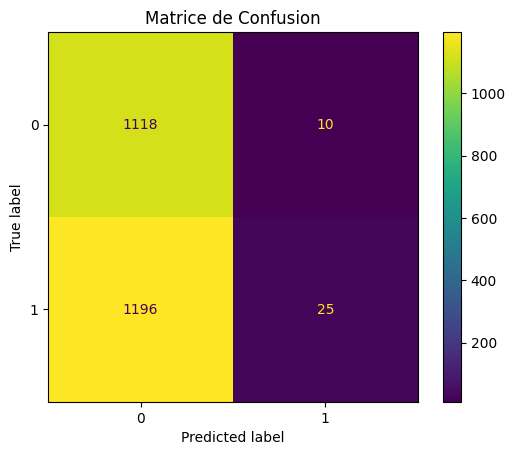

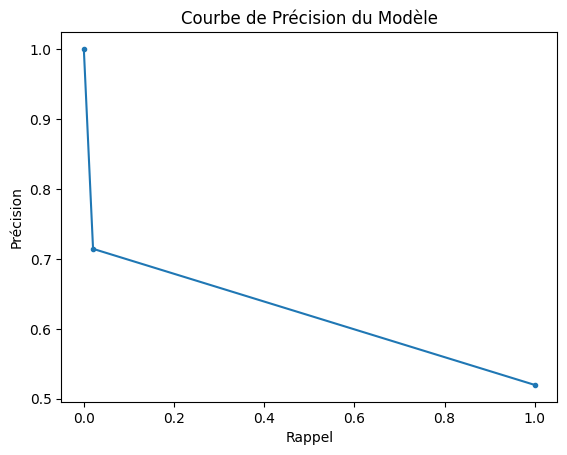

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt

# Définir un seuil pour la classification binaire
threshold = 7.0

# Créer les vecteurs pour les vraies valeurs et les prédictions binaires
y_true = np.array([1 if pred.r_ui >= threshold else 0 for pred in predictions])
y_pred = np.array([1 if pred.est >= threshold else 0 for pred in predictions])

# Calculer la précision du modèle
accuracy = accuracy_score(y_true, y_pred)
print(f"Précision du modèle binaire : {accuracy:.2f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
plt.title('Matrice de Confusion')
plt.show()

# Tracer la courbe de précision-rappel
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision, marker='.')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de Précision du Modèle')
plt.show()


Threshold: 6.5
Précision du modèle binaire : 0.76


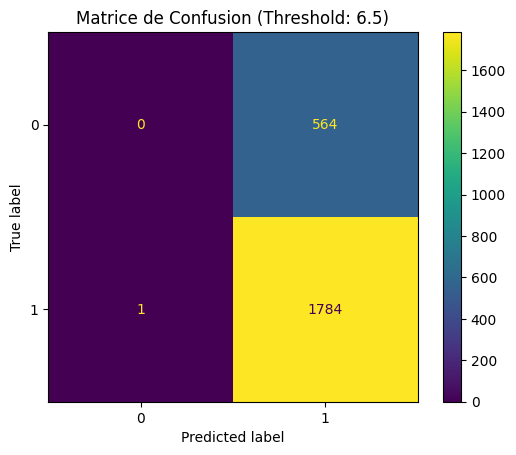

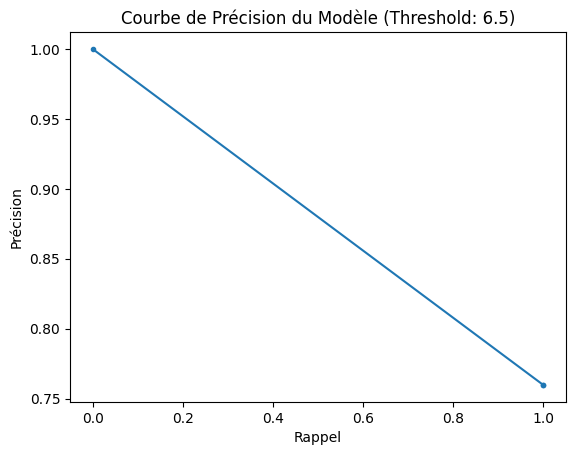

Threshold: 7.0
Précision du modèle binaire : 0.49


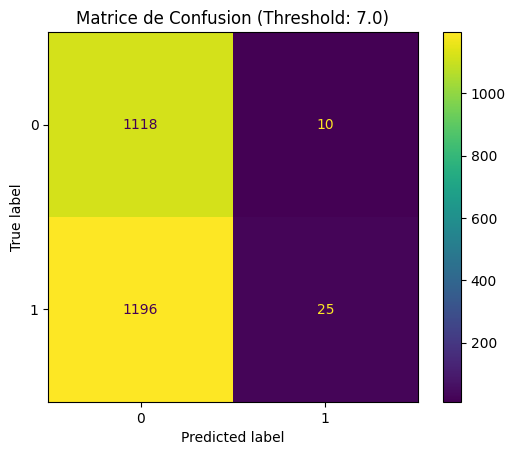

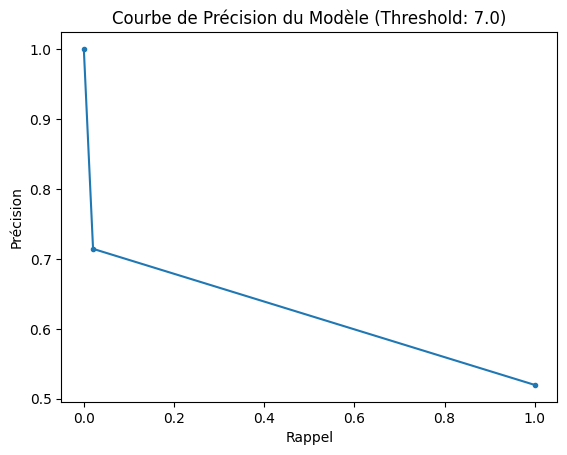

Threshold: 7.5
Précision du modèle binaire : 0.72


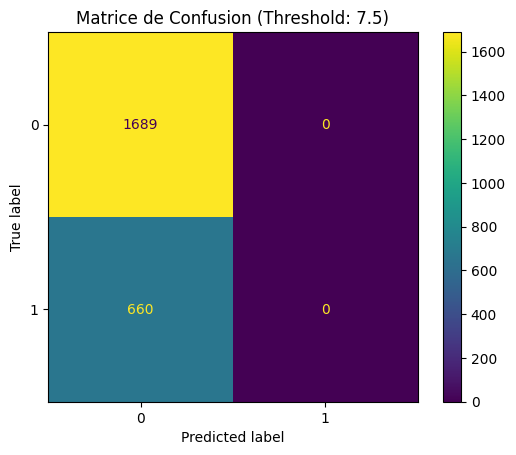

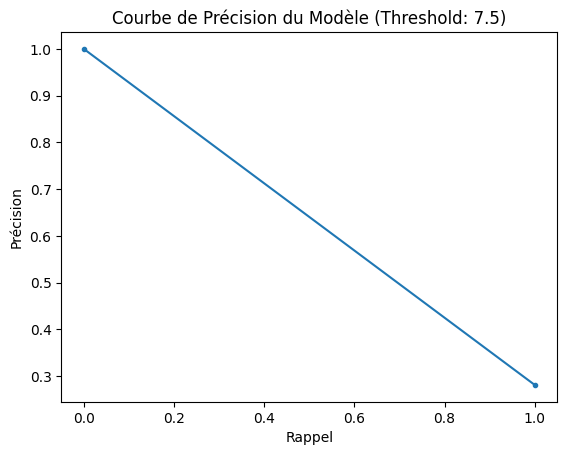

Threshold: 8.0
Précision du modèle binaire : 0.88


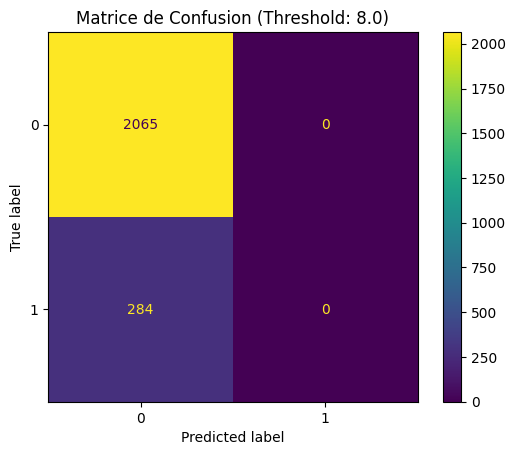

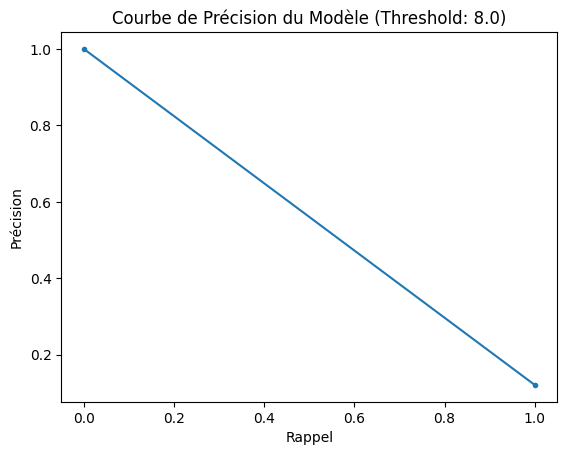

In [62]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt

thresholds = [6.5, 7.0, 7.5, 8.0]
for threshold in thresholds:
    print(f"Threshold: {threshold}")
    y_true = np.array([1 if pred.r_ui >= threshold else 0 for pred in predictions])
    y_pred = np.array([1 if pred.est >= threshold else 0 for pred in predictions])

    # Calculer la précision du modèle
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Précision du modèle binaire : {accuracy:.2f}")

    # Générer la matrice de confusion
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    conf_matrix_display.plot()
    plt.title(f'Matrice de Confusion (Threshold: {threshold})')
    plt.show()

    # Tracer la courbe de précision-rappel
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Rappel')
    plt.ylabel('Précision')
    plt.title(f'Courbe de Précision du Modèle (Threshold: {threshold})')
    plt.show()


Précision du modèle binaire : 0.76


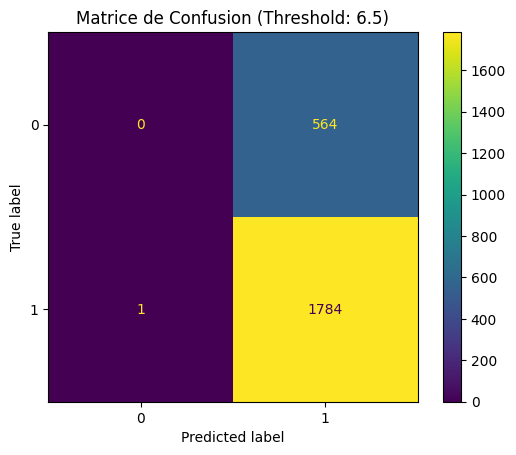

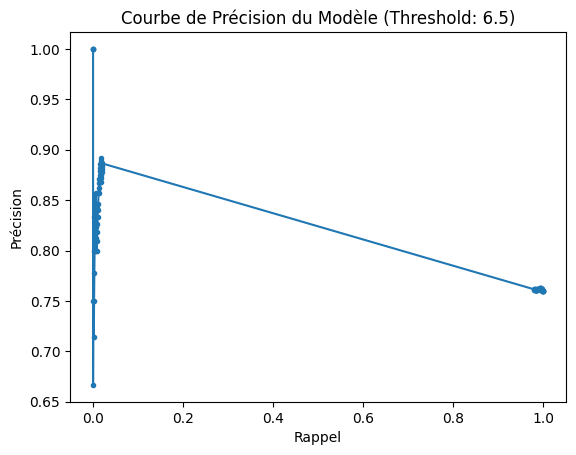

In [64]:
import numpy as np
from sklearn.metrics import precision_recall_curve, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Définir le seuil pour la classification binaire
threshold = 6.5

# Créer les vecteurs pour les vraies valeurs et les prédictions binaires
y_true = np.array([1 if pred.r_ui >= threshold else 0 for pred in predictions])
y_scores = np.array([pred.est for pred in predictions])  # Utilisation des scores continus

# Calculer la précision du modèle binaire
y_pred_binary = np.array([1 if score >= threshold else 0 for score in y_scores])
accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Précision du modèle binaire : {accuracy:.2f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_binary)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
plt.title(f'Matrice de Confusion (Threshold: {threshold})')
plt.show()

# Tracer la courbe de précision-rappel en utilisant les scores continus
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.plot(recall, precision, marker='.')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title(f'Courbe de Précision du Modèle (Threshold: {threshold})')
plt.show()


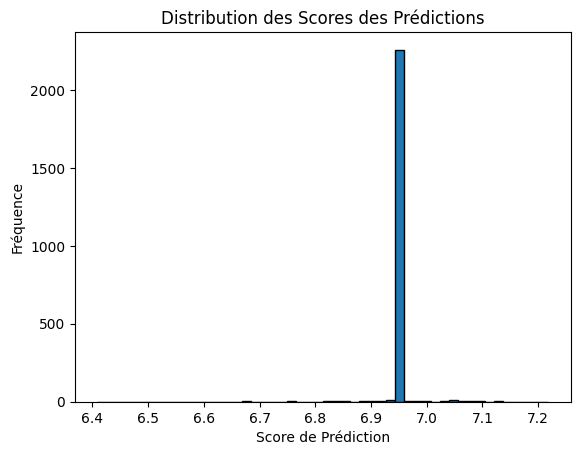

In [65]:
plt.hist(y_scores, bins=50, edgecolor='black')
plt.title('Distribution des Scores des Prédictions')
plt.xlabel('Score de Prédiction')
plt.ylabel('Fréquence')
plt.show()
